In [1]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import awkward as ak
import vector
import os
vector.register_awkward()
import mplhep
plt.style.use(mplhep.style.CMS)

In [2]:
file = uproot.open("/eos/user/d/ddharmen/updated_cmssw/CMSSW_14_0_0_pre3/src/FastPUPPI/NtupleProducer/python/SC/perfNano.root")
print(file.keys())
data = file["Events"]

['Events;1', 'LuminosityBlocks;1', 'Runs;1', 'MetaData;1', 'ParameterSets;1']


In [3]:
def getBranch(data, l1jet):
    
    # Get list of branches relating to the given jet
    print("Getting list of interesting branches")
    interestingBranches = [branch for branch in data.keys() if l1jet in branch and not f"n{l1jet}" in branch]# and not f"{l1jet}_dau0" in branch] 
    
    # Get only branches corresponding to the desired l1jet
    print("Querying the array with interesting branches")
    l1jetData = data.arrays(interestingBranches)
    
    
    # Get a dictionary relating default branch names to new branch names (ie without leading ak8PuppiJets_...)
    print("Splitting branch names on _ to get renamed fields")
    renamedFields = {field : field.split('_', maxsplit=1)[-1] for field in interestingBranches}

    # Create a new awkward array with the desired l1jet branches and the new branch names
    print("Returning an ak array of the relevant data with the renamed fields")
    arr = ak.Array({renamedFields[field]: l1jetData[field] for field in l1jetData.fields})
    
    
    array_dict = {key: arr[key] for key in arr.fields}
    quarks4mom = ak.zip(array_dict)
    quarks4mom = ak.with_name(quarks4mom, "Momentum4D")
    
    
    return quarks4mom

In [4]:
hsc8Jets_DC = getBranch(data=data, l1jet="HSC9x9SC8DCJets_")
hsc8Jets = getBranch(data=data, l1jet="HSC9x9SC8Jets_")
sc8Jets = getBranch(data=data, l1jet="HSC9x9SC8SCJets_")

Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields
Getting list of interesting branches
Querying the array with interesting branches
Splitting branch names on _ to get renamed fields
Returning an ak array of the relevant data with the renamed fields


In [5]:
num_jets_sc = ak.num(sc8Jets)
num_jets_hsc_dc = ak.num(hsc8Jets_DC)
num_jets_hsc = ak.num(hsc8Jets)

valid_events_sc = num_jets_sc >= 4
valid_events_hsc_dc = num_jets_hsc_dc >= 4
valid_events_hsc = num_jets_hsc >= 4


print(ak.to_list(sc8Jets[:1]))
fourth_jet_sc = sc8Jets[valid_events_sc][:, 3] #fourth jet
fourth_jet_hsc_DC = hsc8Jets_DC[valid_events_hsc_dc][:, 3] #fourth jet
fourth_jet_hsc = hsc8Jets[valid_events_hsc][:, 3] #fourth jet

[[{'pt': 226.25, 'eta': 1.0032234191894531, 'phi': 3.041116952896118, 'mass': 0.0, 'genpt': 298.46575927734375, 'geneta': 1.238577127456665, 'genphi': 2.9451375007629395, 'gendeltar': 0.2541719973087311, 'genmass': 124.23139953613281, 'nDau': 28.0}, {'pt': 204.25, 'eta': -0.2968252897262573, 'phi': 0.16106799244880676, 'mass': 0.0, 'genpt': 205.03102111816406, 'geneta': -0.28498920798301697, 'genphi': 0.13120220601558685, 'gendeltar': 0.03212565928697586, 'genmass': 46.750732421875, 'nDau': 21.0}, {'pt': 108.0, 'eta': 0.6718835830688477, 'phi': 0.780796229839325, 'mass': 0.0, 'genpt': 102.79945373535156, 'geneta': 0.6801227331161499, 'genphi': 0.7532574534416199, 'gendeltar': 0.028744859620928764, 'genmass': 18.06937026977539, 'nDau': 7.0}, {'pt': 62.0, 'eta': -0.5974855422973633, 'phi': -0.7462816834449768, 'mass': 0.0, 'genpt': 58.991851806640625, 'geneta': -0.6092051267623901, 'genphi': -0.824233889579773, 'gendeltar': 0.07882827520370483, 'genmass': 13.317244529724121, 'nDau': 5.0}

In [6]:
fourth_jet_sc.pt
fourth_jet_hsc_DC.pt

<Array [131, 21, 25.2, ... 38.8, 44, 65.8] type='1990 * float32'>

In [20]:
fixedThresh = 40   #threshold
fourth_jet_genpt = fourth_jet_hsc_DC.genpt
fourth_jet_pt = fourth_jet_hsc_DC.pt
l1_jet4_passedThresh = fourth_jet_pt > fixedThresh

ht_bins = np.linspace(0, 300, 40)       #bins or x-range
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_hsc_DC = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (fourth_jet_genpt >= ht_bins[binn]) & (fourth_jet_genpt < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_jet4_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_hsc_DC.append(numerator/denominator)

/tmp/ipykernel_560/2928522003.py:15: RuntimeWarning: invalid value encountered in long_scalars
  efficiencies_hsc_DC.append(numerator/denominator)


In [21]:
fourth_jet_genpt = fourth_jet_hsc.genpt
fourth_jet_pt = fourth_jet_hsc.pt
l1_jet4_passedThresh = fourth_jet_pt > fixedThresh

ht_bins = np.linspace(0, 300, 40)       #bins or x-range
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_hsc = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (fourth_jet_genpt >= ht_bins[binn]) & (fourth_jet_genpt < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_jet4_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_hsc.append(numerator/denominator)

/tmp/ipykernel_560/2005337814.py:14: RuntimeWarning: invalid value encountered in long_scalars
  efficiencies_hsc.append(numerator/denominator)


In [22]:
fourth_jet_genpt = fourth_jet_sc.genpt
fourth_jet_pt = fourth_jet_sc.pt
l1_jet4_passedThresh = fourth_jet_pt > fixedThresh

ht_bins = np.linspace(0, 300, 40)       #bins or x-range
bin_centres = (ht_bins[:-1] + ht_bins[1:]) / 2
efficiencies_sc = []
for binn in range(len(ht_bins) - 1):
    inBinMask = (fourth_jet_genpt >= ht_bins[binn]) & (fourth_jet_genpt < ht_bins[binn + 1])
    
    numerator = ak.sum(l1_jet4_passedThresh[inBinMask])
    denominator = ak.sum(inBinMask)
    
    efficiencies_sc.append(numerator/denominator)

/tmp/ipykernel_560/785573423.py:14: RuntimeWarning: invalid value encountered in long_scalars
  efficiencies_sc.append(numerator/denominator)


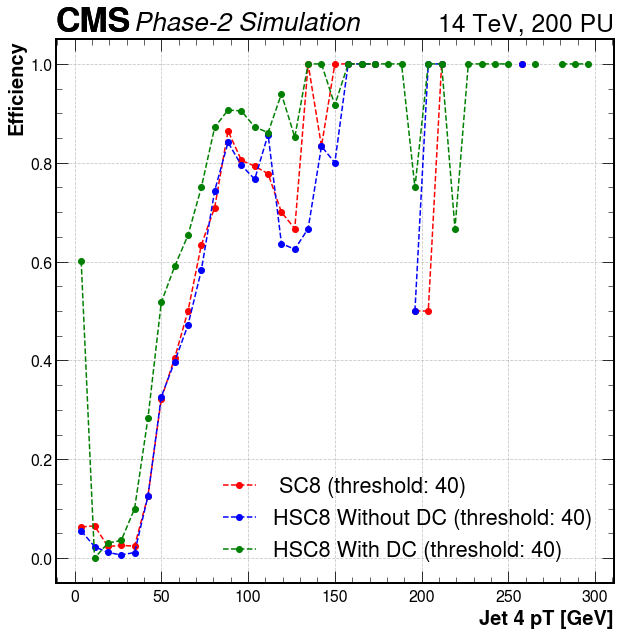

In [23]:
plt.style.use(mplhep.style.ROOT)


# Plotting the efficiencies with matplotlib
plt.plot(bin_centres, efficiencies_sc, marker='o', linestyle='--', color='r', label=f' SC8 (threshold: {fixedThresh})')
plt.plot(bin_centres, efficiencies_hsc, marker='o', linestyle='--', color='b', label=f'HSC8 Without DC (threshold: {fixedThresh})')
plt.plot(bin_centres, efficiencies_hsc_DC, marker='o', linestyle='--', color='g', label=f'HSC8 With DC (threshold: {fixedThresh})')


Jet_n="Jet_4"
# Set axis labels and title
plt.xlabel('Jet 4 pT [GeV]', fontsize=20, fontweight='bold')
plt.ylabel('Efficiency', fontsize=20, fontweight='bold')
plt.title('', fontsize=16)

# Add grid and customize tick marks
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

# Add a legend
plt.legend()
# mplhep.style.use({"font.sans-serif":'Comic Sans MS'})
mplhep.cms.text("Phase-2 Simulation")
# mplhep.cms.text("")
# mplhep.cms.label("Phase-2 Simulation", com= 14, rlabel = "",llabel="")
mplhep.cms.label("",llabel="",rlabel="14 TeV, 200 PU")
# mplhep.cms.text("")
# Show the plot
plt.savefig(f"{Jet_n}_perf.pdf", format="pdf", bbox_inches="tight")
plt.show()